# Time Series Forecasting

<span>This notebook demonstrates my solution to a time series problem posted on Kaggle. In the dataset, we have near 1 million training records from 1000 stores. We will need to use this information to predict the total sales for each day in the test set. The test set contains 40,000 records. During the modeling process, I created a few benchmark models to compare my final model will. Note that this times series problem is not purely based on the tims series information but alos contains some addition feature on promotions dates. </span>

**Dataset:** [Rosman Store Sales](https://www.kaggle.com/c/rossmann-store-sales/overview)

**Notes**<br>
-- I orginally created a neural networks to forecast this time series, but the network took 9 hours to run on iteration my local machine. Therefore I went with a simpler model.<br>
-- Average model training time is between 20-60 minutes depending on the model.<br>

### Import Preliminaries

In [1]:
# Import generic data science packages
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import modules
import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import missingno as msno
import numpy as np
import pandas as pd
import sqlalchemy
import scipy
import sklearn
import seaborn as sns

import warnings

from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Set pandas options
pd.set_option('max_columns',1000)
pd.set_option('max_rows',30)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set plotting options
mpl.rcParams['figure.figsize'] = (8.0, 7.0)

# Print versions of each package above 
print("Numpy version: {}".format(np.__version__))
print("Pandas version: {}".format(pd.__version__))
print("Sklearn version: {}".format(sklearn.__version__))
print("Scipy version: {}".format(scipy.__version__))

# Moving Average Function


def moving_average(array:np.array, n:int) -> np.array:
    '''
    Return the moving average of the array, givent the time input
    '''
    
    ma = np.cumsum(array, dtype=float)
    ma[n:] = ma[n:] - ma[:-n]
    return ma[n - 1:] / n


# Grid Search Groupby Function
def grid_search_groupby(results: pd.DataFrame, param_1: str, param_2: str) -> pd.DataFrame:
    '''
    Create a aggregated dataframe from the grid search results use the two
    hyper paramters that we pass into the function. We will be using this
    function to plot heatmaps from our grid search.
    
    Parameters
    ----------
    results: DataFrame of Grid Score results.
    param_1: Parameter from Grid Search's Grid
    param_2: Parameter from Grid Search's Grid
    
    Examples
    ----------
    >>> (grid_search_groupby(results,'max_depth','n_estimators')
    >>> grid_search_groupby(results,'max_leaf_nodes','n_estimators')
    '''
    assert (type(results) ==  type(pd.DataFrame())), 'results should be a pandas.core.frame.DataFrame'
    assert (type(param_1) == str), 'param_1 should be a string'
    assert (type(param_2) == str), 'param_2 should be a string'
    
    params_df  = pd.DataFrame.from_dict(list(results.params.values))
    mean_test_score = results.mean_test_score
    result_shrt_df = pd.concat([mean_test_score, params_df], axis=1)
    result_groupby = result_shrt_df.groupby([param_1, param_2])['mean_test_score'].mean().unstack()
    return result_groupby

def append_missing_columns(train_df:pd.DataFrame,
                           test_df: pd.DataFrame) -> pd.DataFrame:
    '''
    Makes sure that both the training and testing set have the 
    same features by appeding any feature that are missing in 
    the test set and train set by comparing each dataframes
    feature.
    
    Parameters
    ----------
    train_df: The training dataframe after feature engineering
    test_df: The testing dataframe after feature engineesing
    
    '''

    
    mis_train_col= [i for i in test_df.columns if i not in train_df.columns]
    mis_test_cols = [i for i in train_df.columns if i not in test_df.columns]

    for col in mis_train_col:
        train_df[col] = 0
    for col in mis_test_cols:
        test_df[col] = 0
        
    train_df = train_df.sort_index(axis=1)
    test_df = test_df.sort_index(axis=1)
    
    return train_df, test_df


Numpy version: 1.13.1
Pandas version: 0.23.3
Sklearn version: 0.19.0
Scipy version: 0.19.1


### Import Data

The training and testing set have been given to us into separate CSV files, with an external file for the additional "store" data. I found empty string values in the data after importing the tabls from SQL, I wrote a quick "for" loop in the cell below, changing these empty string to null values. We will address how to handle the null values later on.

In [2]:
# Set your local database parameters 
db_username = 'root'
db_password = 'mypassword'
host = '127.0.0.1'
port = '3306'
db_name = 'rossman'

# Create a MySQLEngine
engine = sqlalchemy.create_engine('mysql+mysqldb://'+db_username+':'+db_password+'@\
'+host+':'+port+'/'+db_name)

# Connect to database
engine.connect();

# Import data from SQL
train_df = pd.read_csv('Data/Rossman/train.csv')
test_df = pd.read_csv('Data/Rossman/test.csv')
stores = pd.read_sql(""" SELECT * FROM store""", engine,
                     ).dropna(how='any', axis=0)

# Rename salse column to target
train_df.rename(columns={'Sales':'target'}, inplace=True)
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Replace empty string in store dataframe with Null Values
for col in stores:
    stores[col] = stores[col].replace('',np.nan)

    
# View head of store dataframe
stores.head(10)

/Users/kavi/anaconda3/envs/main/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.000,9,2008,0,NaN,NaN,NaN
1,2,a,a,570.000,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.000,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620.000,9,2009,0,NaN,NaN,NaN
4,5,a,a,29910.000,4,2015,0,NaN,NaN,NaN
5,6,a,a,310.000,12,2013,0,NaN,NaN,NaN
6,7,a,c,24000.000,4,2013,0,NaN,NaN,NaN
7,8,a,a,7520.000,10,2014,0,NaN,NaN,NaN
8,9,a,c,2030.000,8,2000,0,NaN,NaN,NaN
9,10,a,a,3160.000,9,2009,0,NaN,NaN,NaN


In [3]:
# View head of the test dataframe
test_df.head(10)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.000,1,0,0
1,2,3,4,2015-09-17,1.000,1,0,0
2,3,7,4,2015-09-17,1.000,1,0,0
3,4,8,4,2015-09-17,1.000,1,0,0
4,5,9,4,2015-09-17,1.000,1,0,0
5,6,10,4,2015-09-17,1.000,1,0,0
6,7,11,4,2015-09-17,1.000,1,0,0
7,8,12,4,2015-09-17,1.000,1,0,0
8,9,13,4,2015-09-17,1.000,1,0,0
9,10,14,4,2015-09-17,1.000,1,0,0


In [4]:
# View head of the train dataframe
train_df.head(10)

,Store,DayOfWeek,Date,target,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
5,6,5,2015-07-31,5651,589,1,1,0,1
6,7,5,2015-07-31,15344,1414,1,1,0,1
7,8,5,2015-07-31,8492,833,1,1,0,1
8,9,5,2015-07-31,8565,687,1,1,0,1
9,10,5,2015-07-31,7185,681,1,1,0,1


### Data Completness


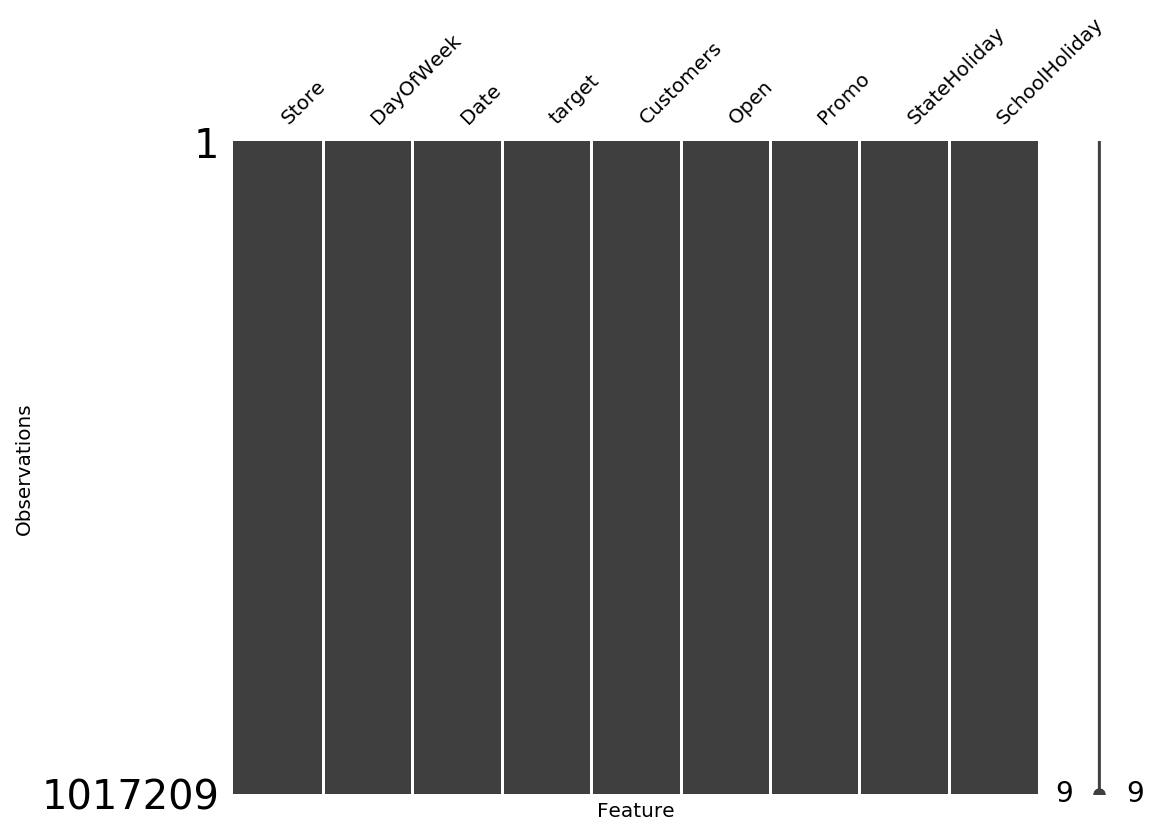

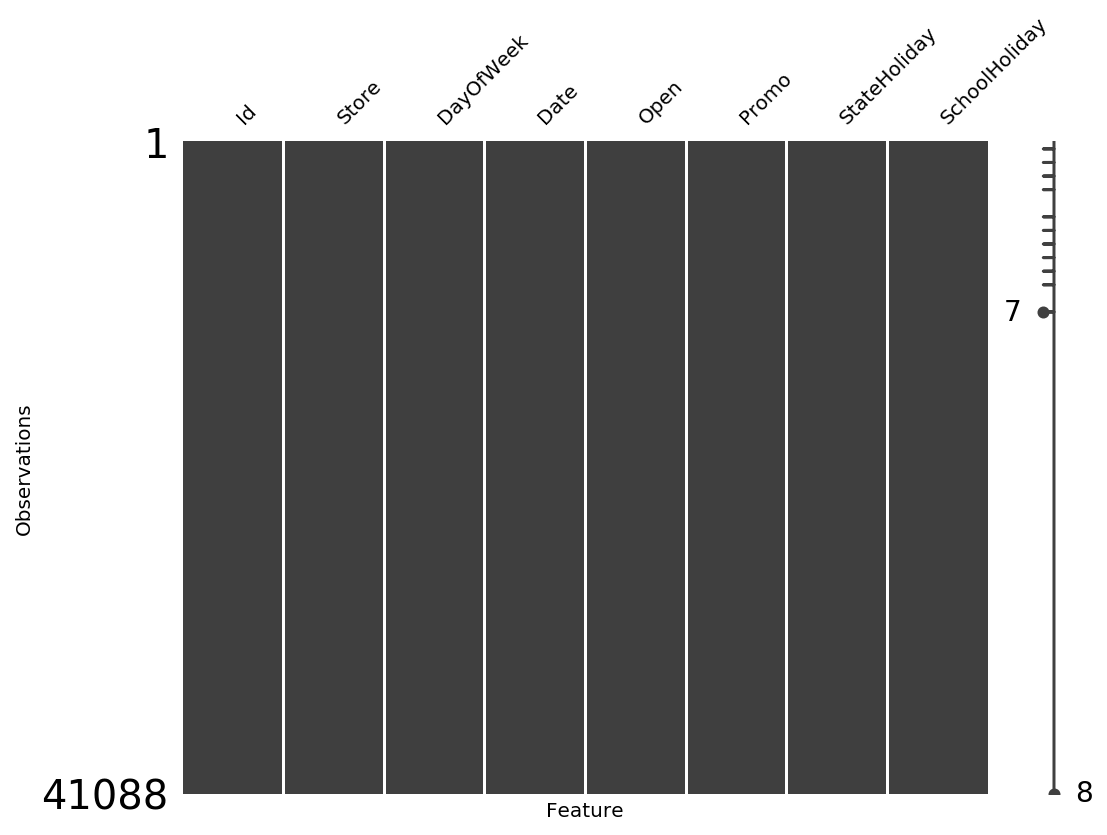

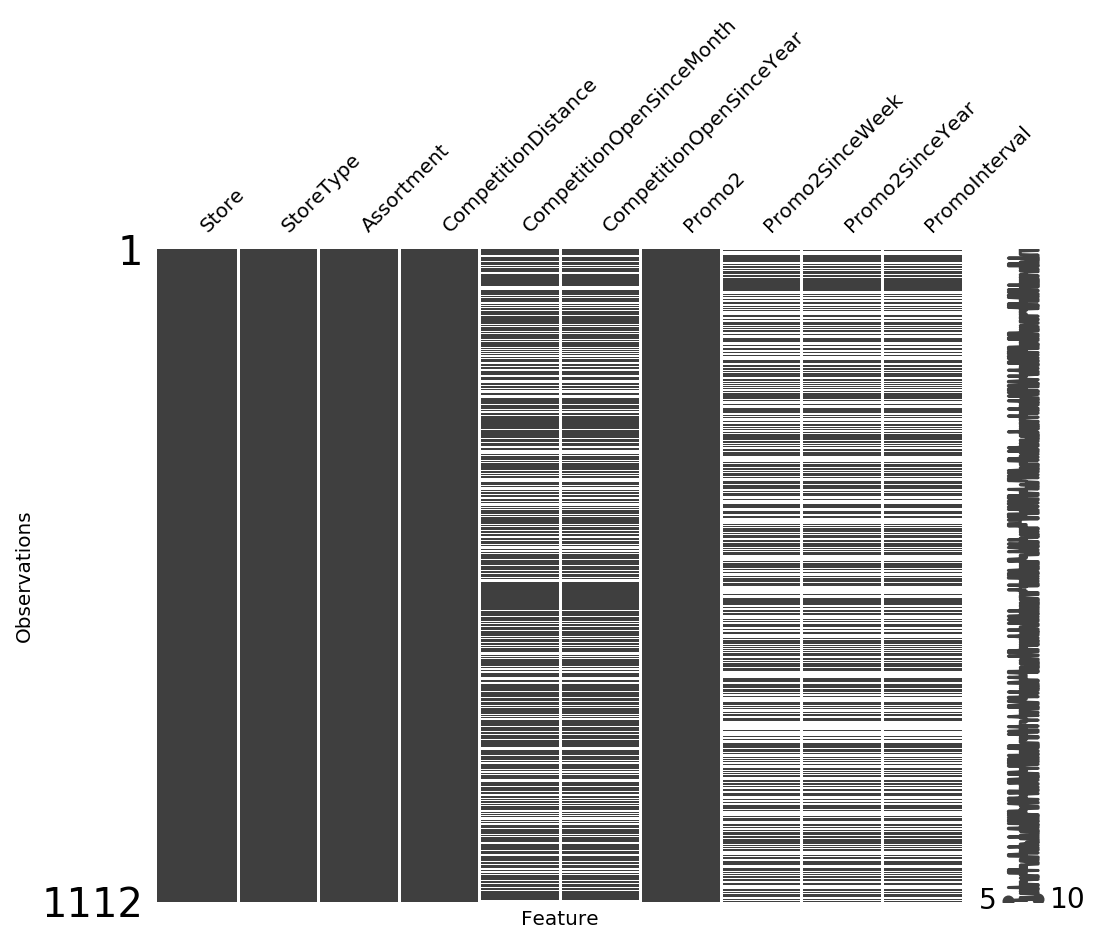

In [5]:
# Plot the null values from train, tets, and store dataframes
msno.matrix(train_df,  figsize=(8,6), fontsize=10);
plt.xlabel('Feature')
plt.ylabel('Observations');

msno.matrix(test_df,  figsize=(8,6), fontsize=10);
plt.xlabel('Feature')
plt.ylabel('Observations');

msno.matrix(stores,  figsize=(8,6), fontsize=10);
plt.xlabel('Feature')
plt.ylabel('Observations');

The training and testing are really clean but the store data seems to have many missing value for in couple of the features. I will address our methodology on how to handle these missing value under the "Feature Engineering" subsection.

### Data Overview

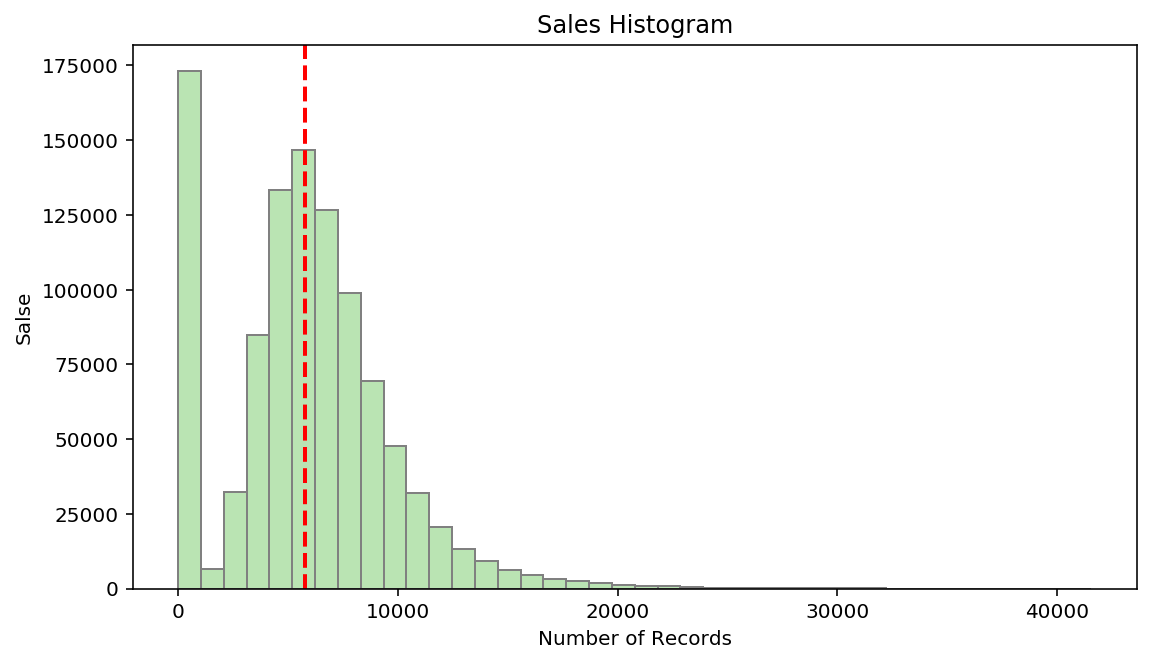

In [6]:
# Plot the distribution of target classes
train_df.target.plot.hist(figsize=(9,5),color='#BAE4B3',
                          bins=40,
                          edgecolor='grey')
plt.axvline(train_df.target.mean(), color='r', linestyle='dashed', 
            linewidth=2);
plt.title('Sales Histogram')
plt.ylabel('Salse')
plt.xlabel('Number of Records');

We have this spike in the first bin telling us that we have many values near 0. This is normal given the contextual information about the time series. Store in this datset are normally closed on the weekend, except in a few locations/days.

In [7]:
# Print the median, mean, and standard deviation for Sunday
print(f"Day 7 Number of Records: {len(train_df[train_df.DayOfWeek == 7]['target'])}")
print(f"Day 7 Sales Median: {train_df[train_df.DayOfWeek == 7]['target'].median()}")
print(f"Day 7 Sales: Mean: {train_df[train_df.DayOfWeek == 7]['target'].mean()}")
print(f"Day 7 Sales Standard Deviation: {train_df[train_df.DayOfWeek == 7]['target'].std()}")

Day 7 Number of Records: 144730
Day 7 Sales Median: 0.0
Day 7 Sales: Mean: 204.18318938713466
Day 7 Sales Standard Deviation: 1613.2435172682563


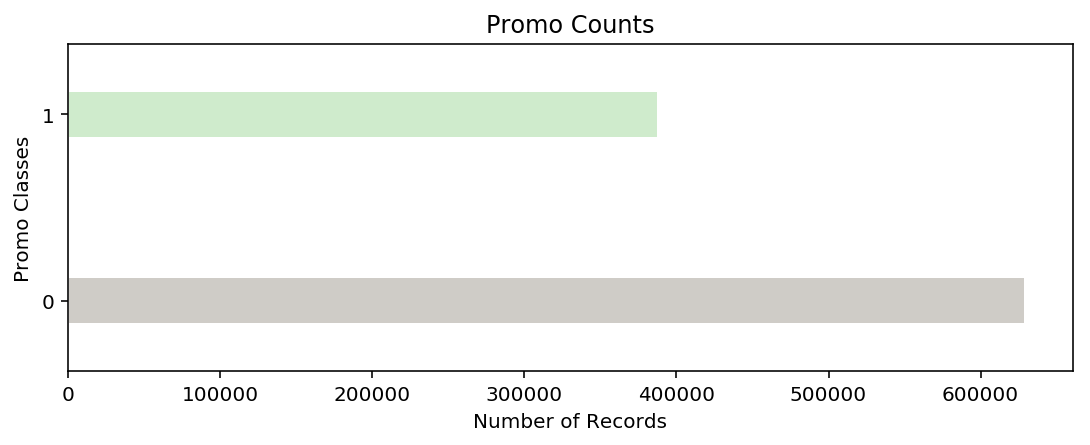

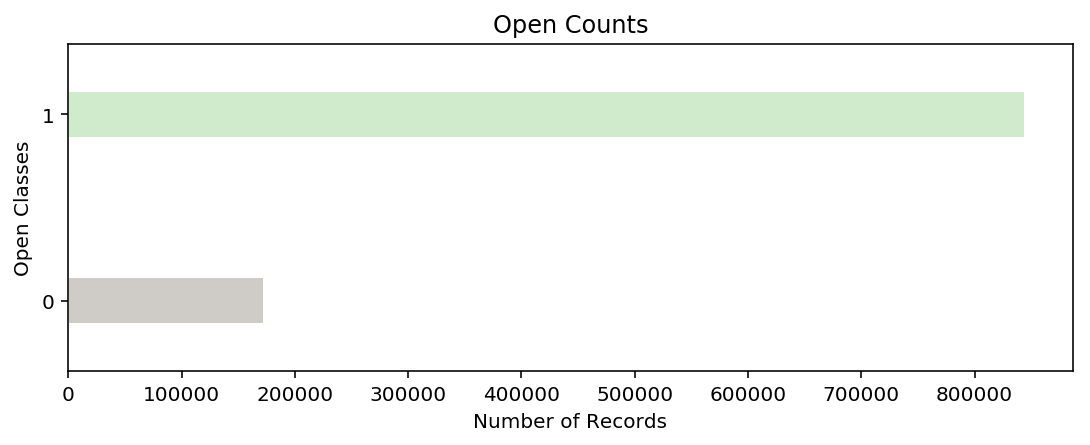

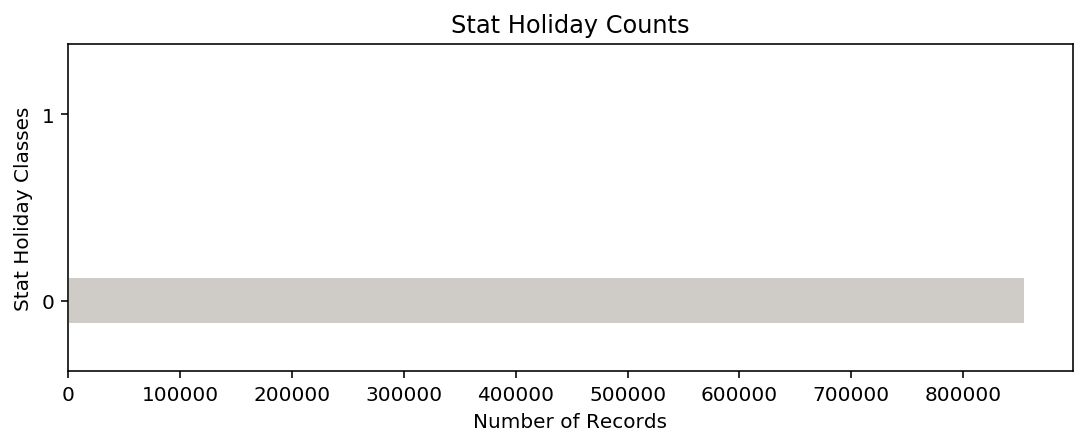

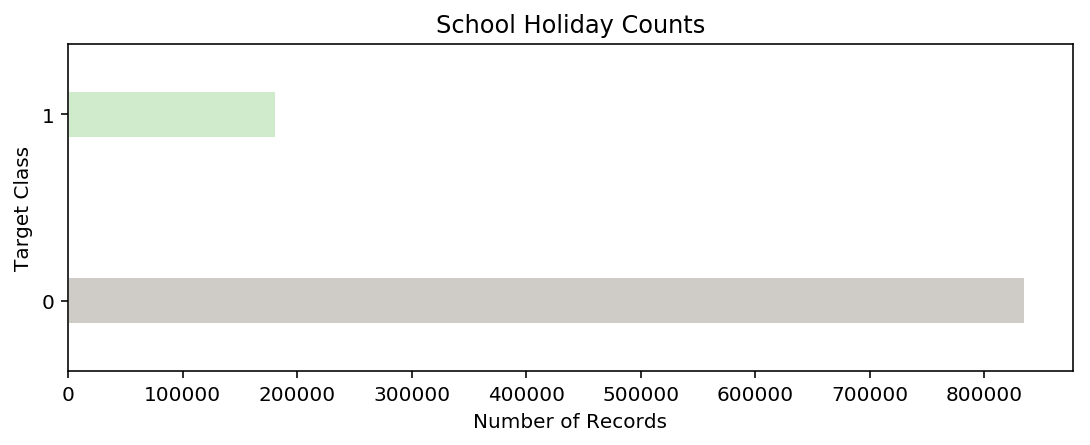

In [8]:
# Plot counts for day where promos were active 
plt.figure()
promo_counts = train_df.Promo.value_counts()
promo_counts.plot.barh(figsize=(9,3),grid=False, 
                      color=['#CFCCC7','#CFEBCC'],
                      width=0.25,edgecolor='w')
plt.title('Promo Counts')
plt.ylabel('Promo Classes')
plt.xlabel('Number of Records');


# Plot counts for days in the dataset a store is open
plt.figure()
open_counts = train_df.Open.value_counts(ascending=True)
open_counts.plot.barh(figsize=(9,3),grid=False, 
                      color=['#CFCCC7','#CFEBCC'],
                      width=0.25,edgecolor='w')
plt.title('Open Counts')
plt.ylabel('Open Classes')
plt.xlabel('Number of Records');

# Plot number of time that we are open during state holidary (probably never)
plt.figure()
sthol_counts = train_df.StateHoliday.value_counts()
sthol_counts = pd.Series([sthol_counts.values[0], 0 ]) # plotting fix
sthol_counts.plot.barh(figsize=(9,3),grid=False, 
                       color=['#CFCCC7','#CFEBCC'], 
                       width=0.25,edgecolor='w')
plt.title('Stat Holiday Counts')
plt.ylabel('Stat Holiday Classes')
plt.xlabel('Number of Records');

# Plot the number of days in the datset that are affected by school holidays
plt.figure()
schol_counts = train_df.SchoolHoliday.value_counts()
schol_counts.plot.barh(figsize=(9,3),grid=False, 
                       color=['#CFCCC7','#CFEBCC'], 
                       width=0.25,edgecolor='w')
plt.title('School Holiday Counts')
plt.ylabel('Target Class')
plt.xlabel('Number of Records');

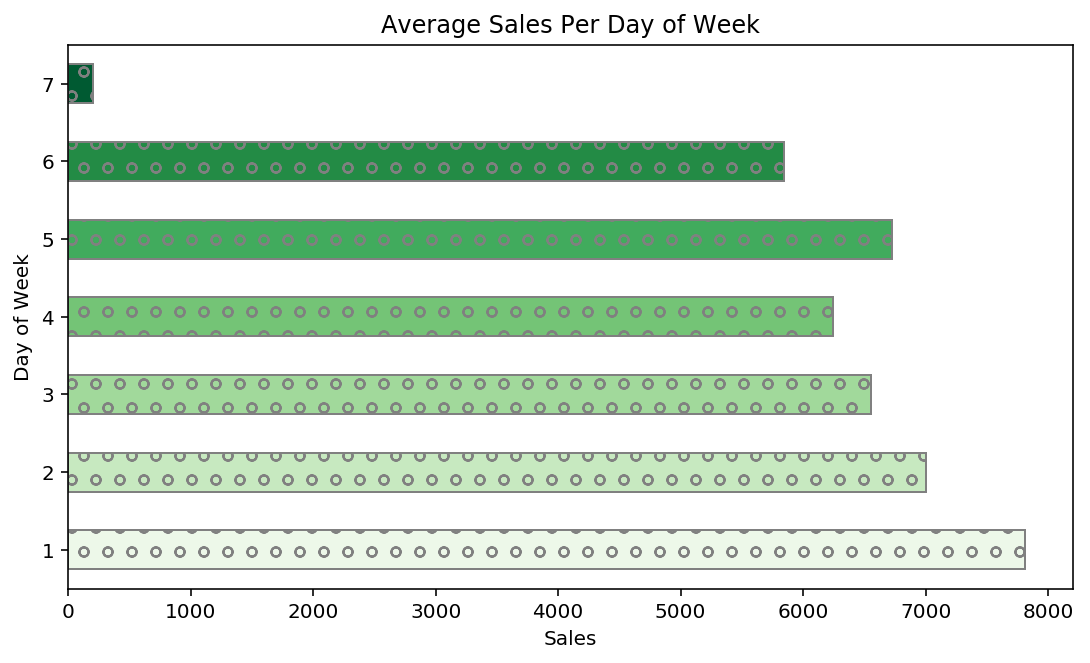

In [9]:
# plot sales by day of the week
sales_by_week = train_df.groupby('DayOfWeek')['target'].mean()
sales_by_week.plot.barh(
                figsize = (9,5),
                grid=False, 
                color=['#edf8e9','#c7e9c0','#a1d99b','#74c476',
                  '#41ab5d','#238b45','#005a32'], 
                width=0.5, edgecolor='grey',
                hatch='o')
plt.title('Average Sales Per Day of Week')
plt.ylabel('Day of Week')
plt.xlabel('Sales');


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
target           1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


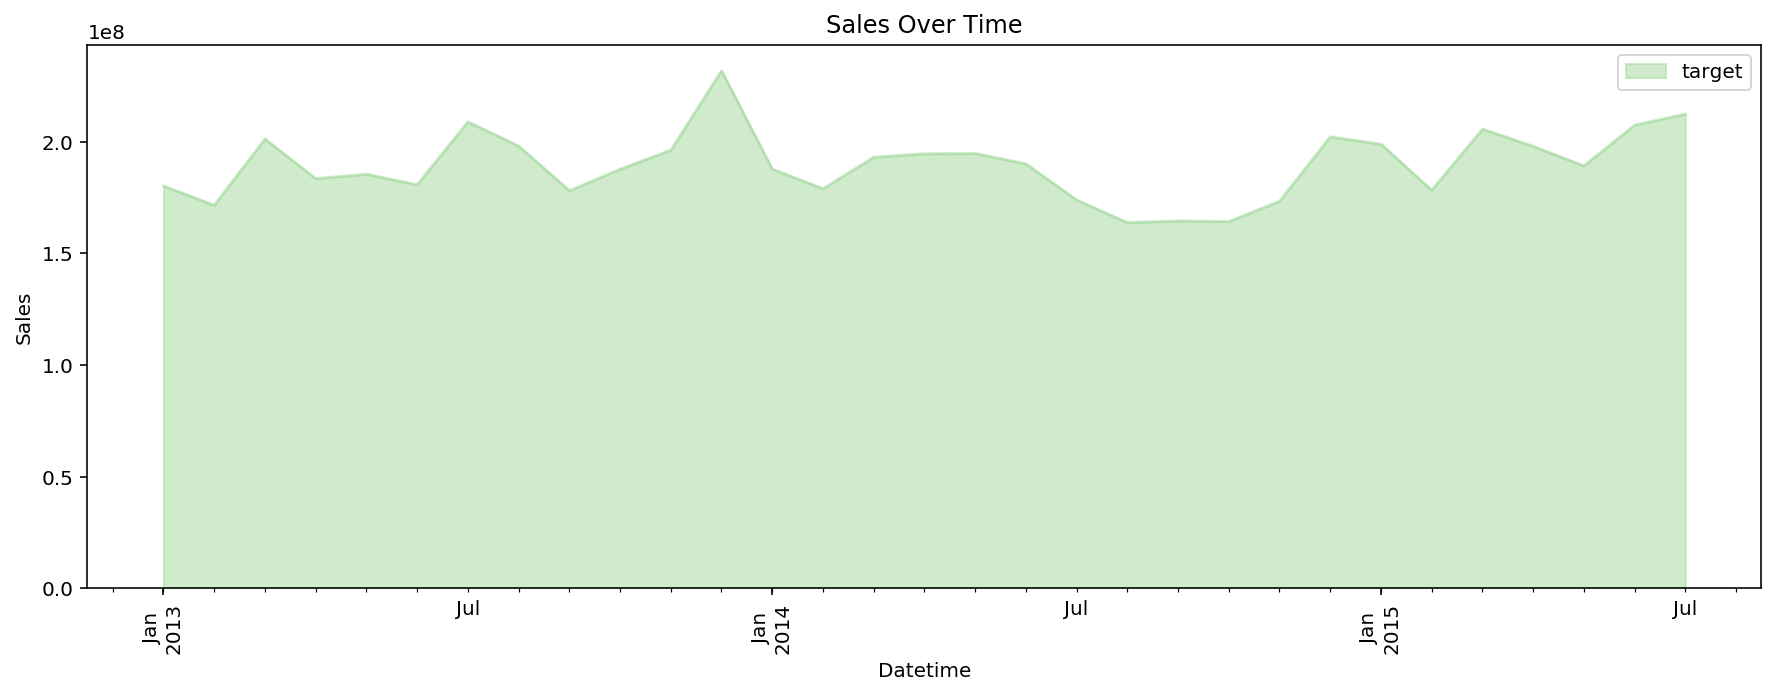

In [11]:
# Plot a line plot showing growth by year
annual_growth = train_df.set_index('Date')
annual_growth = annual_growth.resample('1M').sum()
annual_growth.plot.area(y='target', figsize=(15,5), 
                        color='#A1D99B', alpha=0.5)
plt.xticks(rotation='vertical')
plt.title('Sales Over Time')
plt.xlabel('Datetime')
plt.ylabel('Sales');

The dependent variable look pretty stationary. Good from a forecasting perspective, not best for the as sales seem to be stagnating. Let take a look at the annual and monthly growth

In [12]:
# Print the growth number for Rossman
print(f'Dataset Data Range is from {train_df.Date.max()} to {train_df.Date.min()}.')
growth_df = train_df.set_index('Date').resample('Y').sum()
growth_df['growth'] = growth_df.target.pct_change(periods=1)
growth_df[['target','growth']]

Dataset Data Range is from 2015-07-31 00:00:00 to 2013-01-01 00:00:00.


,target,growth
Date,,
2013-12-31,2302876084,nan
2014-12-31,2180804896,-0.053
2015-12-31,1389499643,-0.363


We can discount the growth number for 2015 as the year has not ended in the dataset, but not a pretty picture for 2014. I Wish this company the best in 2015.

### Data Incosistencies

In [13]:
# Print the featuer names from each dataframe
print('Training Dataset:', train_df.columns, '\n')
print('Testing Dataset:', test_df.columns)

Training Dataset: Index(['Store', 'DayOfWeek', 'Date', 'target', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object') 

Testing Dataset: Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')


We can see that training dataset has a column that is not present in our Testing Set. Therefore let's map the customers count to the stores dataset than merge the total customer counts back into the main testing and training dataframes in the next cells.

In [14]:
# Store customer information seperately
customers_df = train_df[['Store','Customers']]
customers_df = customers_df.groupby('Store')['Customers'].sum().to_frame()
customers_df.rename(columns={'Customers':'Lifetime Customers'}, inplace=True)
train_df = train_df.drop('Customers', axis=1)
customers_df.head(10)

,Lifetime Customers
Store,
1,440523
2,457855
3,584310
4,1036254
5,418588
6,495483
7,745569
8,516027
9,451677


### Data Cleaning

In [15]:
# Copy dataframe for cleaning and feature engineering
train_fdf = train_df.copy()
test_fdf = test_df.copy()
store_fdf = stores.copy()

# Merge store dataframe information into training and test data
train_fdf = train_fdf.merge(stores, how='left', on='Store')
test_fdf = test_fdf.merge(stores, how='left', on='Store')

# Deal will null values from merge, custom rules
train_fdf.CompetitionOpenSinceMonth.fillna(-1, inplace=True)
train_fdf.CompetitionOpenSinceYear.fillna(datetime.datetime.now().year + 1, inplace=True)
train_fdf.Promo2.fillna(-1, inplace=True)
train_fdf.Promo2SinceWeek.fillna(-1, inplace=True)
train_fdf.Promo2SinceYear.fillna(datetime.datetime.now().year + 1, inplace=True)
train_fdf.PromoInterval.fillna('Unknown', inplace=True)

# Deal will null values after merge
train_fdf.Assortment.fillna('Unknown', inplace=True)
train_fdf.StoreType.fillna('Uknown', inplace=True)
train_fdf.CompetitionDistance.fillna(train_fdf.CompetitionDistance.mean(), inplace =True)

# View existing null value of the train dataframe
train_fdf.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
target                       0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [16]:
# Deal will null values from merge, training rules
test_fdf.CompetitionOpenSinceMonth.fillna(-1, inplace=True)
test_fdf.CompetitionOpenSinceYear.fillna(datetime.datetime.now().year + 1, inplace=True)
test_fdf.Promo2.fillna(-1, inplace=True)
test_fdf.Promo2SinceWeek.fillna(-1, inplace=True)
test_fdf.Promo2SinceYear.fillna(datetime.datetime.now().year + 1, inplace=True)
test_fdf.PromoInterval.fillna('Unknown', inplace=True)

# Deal will null values after merge
test_fdf.Assortment.fillna('Unknown', inplace=True)
test_fdf.StoreType.fillna('Uknown', inplace=True)
test_fdf.CompetitionDistance.fillna(train_fdf.CompetitionDistance.mean(), inplace =True)
# Fill remaining null valus within Open feature
test_fdf.fillna(0, inplace=True)


# View existing null value of the test dataframe
test_fdf.isnull().sum()

Id                           0
Store                        0
DayOfWeek                    0
Date                         0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

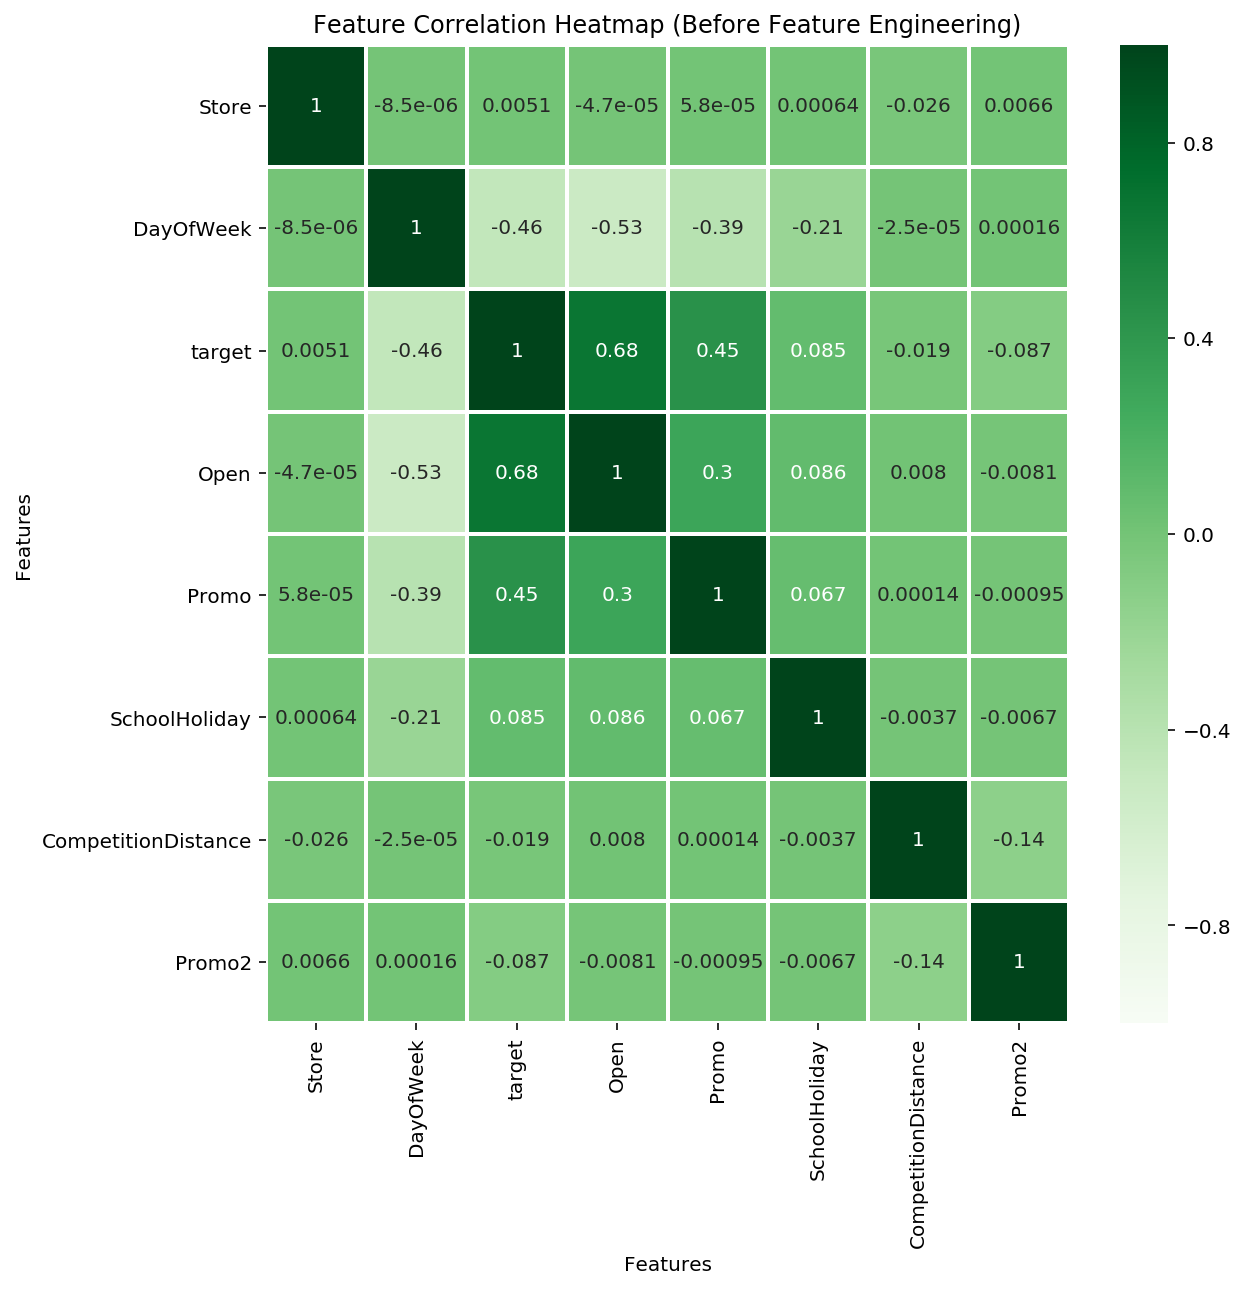

In [17]:
# Plot feature correlation matrix
plt.figure(figsize=(9,9))
sns.heatmap(train_fdf.corr(), cmap=plt.cm.Greens,linewidths=1.5,
           vmin=-1, vmax=1, annot=True)
plt.title('Feature Correlation Heatmap (Before Feature Engineering)')
plt.xlabel('Features')
plt.ylabel('Features');

The strange correlation between StateHoliday and every other feature in the training set is because the StateHoliday feature is an entire feature with just the value "0". Therefore we will remove this feature at the tail end of our feature engineering.

### Feature Engineering

In [18]:
# Append Customer Information
train_fdf = train_fdf.merge(customers_df, how='left', on='Store')
test_fdf = test_fdf.merge(customers_df, how='left', on='Store')


# One Hot Encoding Train Non-Ordinal Feature
train_fdf = pd.get_dummies(train_fdf, drop_first=True,
               columns=['Assortment','Store','StoreType','Promo2',
                        'Promo2SinceYear','PromoInterval'])

# One Hot Encoding Test Non-Ordinal Feature
test_fdf = pd.get_dummies(test_fdf, drop_first=True,
               columns=['Assortment','Store','StoreType','Promo2',
                        'Promo2SinceYear','PromoInterval'])

# Expand Train DateTime Feature
train_fdf['Year'] = train_fdf['Date'].dt.year
train_fdf['Day'] = train_fdf['Date'].dt.day
train_fdf['Month']= train_fdf['Date'].dt.month
train_fdf.drop('Date', axis=1 ,inplace=True)

# Expand Test DateTime Feature
test_fdf['Year'] = test_fdf['Date'].dt.year
test_fdf['Day'] = test_fdf['Date'].dt.day
test_fdf['Month']= test_fdf['Date'].dt.month
test_fdf.drop('Date', axis=1 ,inplace=True)

# Change the Opent Store Year into a Year Ago
train_fdf.CompetitionOpenSinceYear = (train_fdf.CompetitionOpenSinceYear.astype(int) 
                                      - datetime.datetime.now().year)
test_fdf.CompetitionOpenSinceYear = (test_fdf.CompetitionOpenSinceYear.astype(int) 
                                      - datetime.datetime.now().year)
# Drop StateHoliday Feature
train_fdf.drop('StateHoliday', axis=1, inplace=True )
test_fdf.drop('StateHoliday', axis=1, inplace=True)

### Encoding + Split Data

In [19]:
# Clean us some remaining object dtypes into ints
for df in [train_fdf, test_fdf]:
    for col in df.select_dtypes(include='object'):
        df[col] = df[col].astype(int)

train_fdf, test_fdf = append_missing_columns(train_fdf, test_fdf)
# Target Values
y_train = train_fdf.target
X_train = train_fdf.drop('target', axis=1)
X_test = test_fdf.drop('target', axis=1)
print(f'X_Train Data Shape:',X_train.shape)
print(f'y_train Target Shape:',y_train.shape)
print(f'Training Target Shape:',X_test.shape)

# Create KFold cross validation rule without shuffling since we are 
# dealing with a time series
kfold = KFold(n_splits=10, shuffle=False)

X_Train Data Shape: (1017209, 1146)
y_train Target Shape: (1017209,)
Training Target Shape: (41088, 1146)


### Benchmark Model (Linear Regression)

In [20]:
# Linear Regression Pipeline  (20min)
lr_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(), LinearRegression())
lr_scores = cross_validate(lr_pipeline, X_train, y_train, cv=kfold, 
                           scoring=('r2','neg_mean_absolute_error',
                                    'neg_mean_squared_error'))

# Fit the pipline and return predictions
lr_pipeline.fit(X_train,y_train)
lr_pred = lr_pipeline.predict(X_train)

print(f"Linear Regression Cross Validation Score - \
Mean Absolute Erorr: {lr_scores['test_neg_mean_absolute_error'].mean():.5f}")
print(f"Linear Regression Cross Validation Score - \
Mean Squared Erorr: {lr_scores['test_neg_mean_squared_error'].mean():.5f}")
print(f"Linear Regression Cross Validation Score - \
Mean R2 Erorr: {lr_scores['test_r2'].mean():.5f}")

Linear Regression Cross Validation Score - Mean Absolute Erorr: -2233.39970
Linear Regression Cross Validation Score - Mean Squared Erorr: -8413218.41511
Linear Regression Cross Validation Score - Mean R2 Erorr: 0.43256


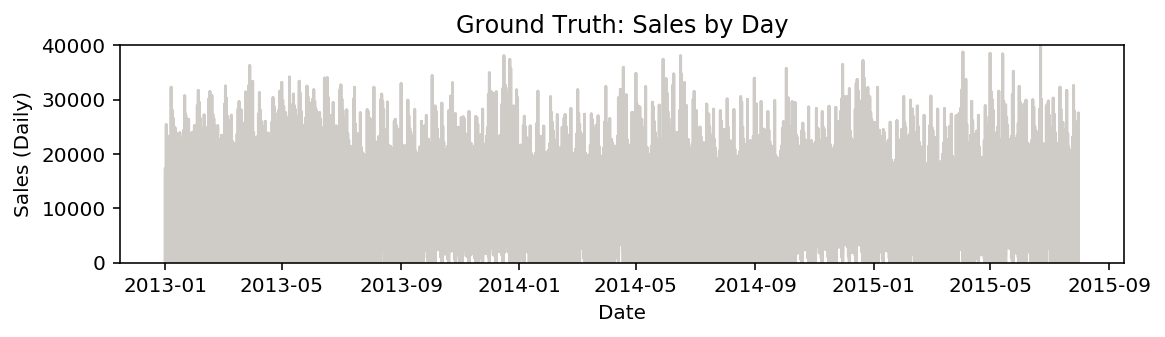

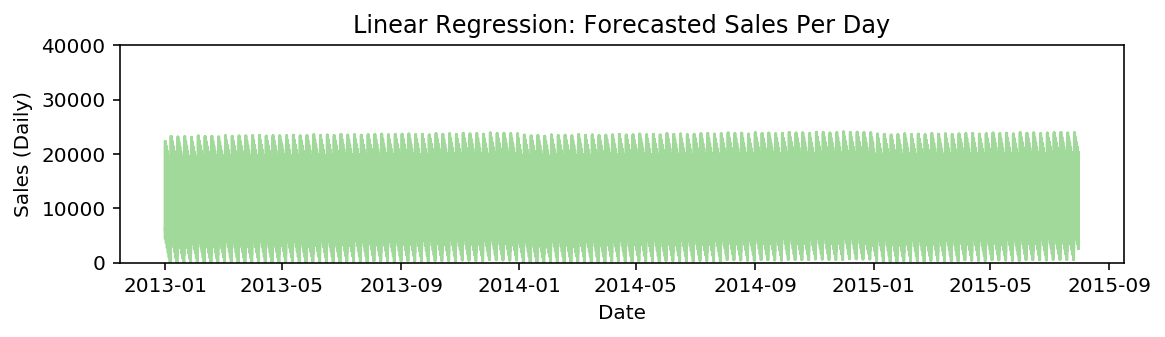

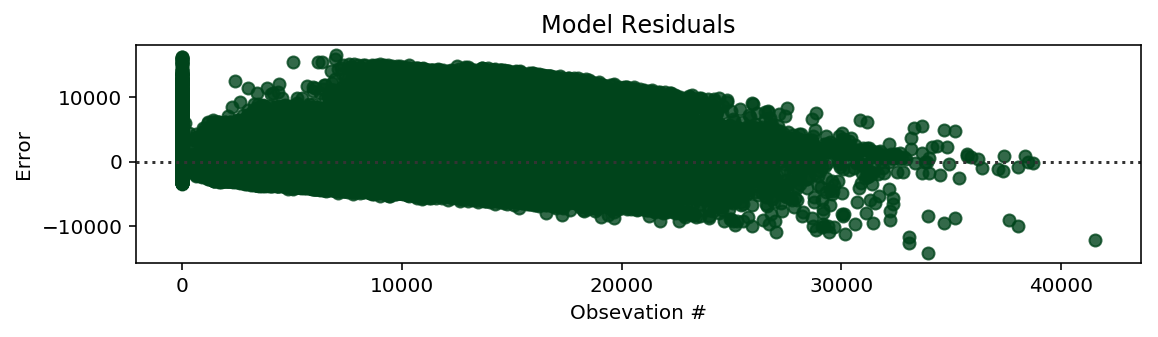

In [21]:
plt.figure(figsize=(9,2))
plt.plot(train_df.Date.values, y_train, color='#CFCCC7')
plt.ylim(0,40_000)
plt.title("Ground Truth: Sales by Day")
plt.ylabel('Sales (Daily)')
plt.xlabel('Date');

plt.figure(figsize=(9,2))
plt.plot(train_df.Date.values, lr_pred, color='#A1D99B')
plt.ylim(0,40_000)
plt.title("Linear Regression: Forecasted Sales Per Day")
plt.ylabel('Sales (Daily)')
plt.xlabel('Date');

# Plotting the residuals of y and pred_y
plt.figure(figsize=(9,2))
sns.residplot(y_train,lr_pred, color='#00441B')
plt.title('Model Residuals')
plt.xlabel('Obsevation #')
plt.ylabel('Error');

### Random Forest Regressor

In [22]:
# Random Forest Pipeline Pipeline (40min)
rfr_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(), 
                             RandomForestRegressor(n_estimators=10))
rfr_scores = cross_validate(rfr_pipeline, X_train, y_train, cv=kfold, 
                           scoring=('r2','neg_mean_absolute_error',
                                    'neg_mean_squared_error'))
# Fit Linear Regression
rfr_pipeline.fit(X_train,y_train)
rfr_pred = rfr_pipeline.predict(X_train)

print(f"Random  Regression Cross Validation Score - \
Mean Absolute Erorr: {rfr_scores['test_neg_mean_absolute_error'].mean():.5f}")
print(f"Random Regression Cross Validation Score - \
Mean Squared Erorr: {rfr_scores['test_neg_mean_squared_error'].mean():.5f}")
print(f"Random Regression Cross Validation Score - \
Mean R2 Erorr: {rfr_scores['test_r2'].mean():.5f}")

Random  Regression Cross Validation Score - Mean Absolute Erorr: -894.39956
Random Regression Cross Validation Score - Mean Squared Erorr: -2577204.70594
Random Regression Cross Validation Score - Mean R2 Erorr: 0.82887


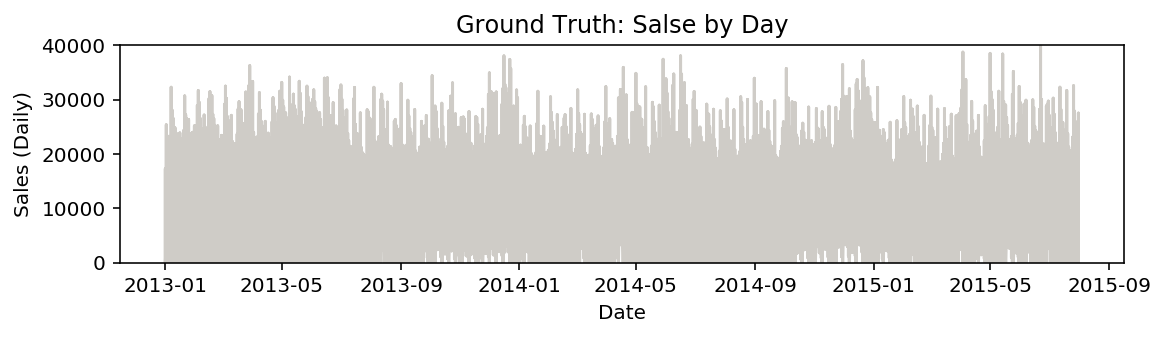

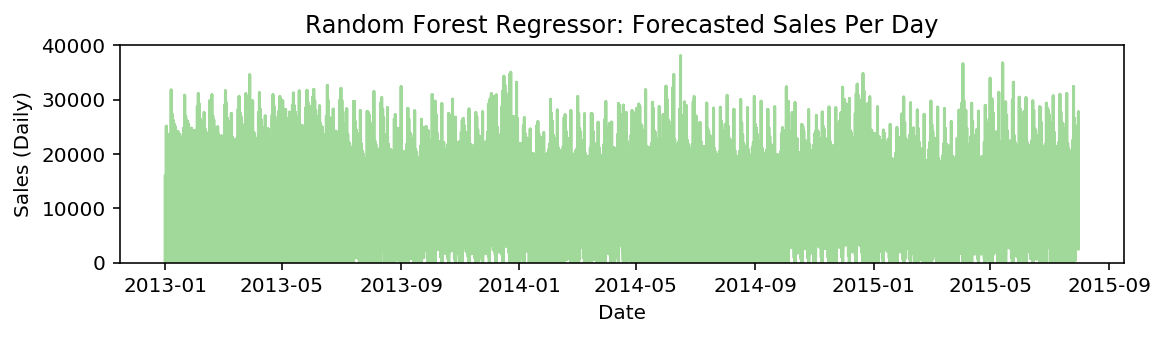

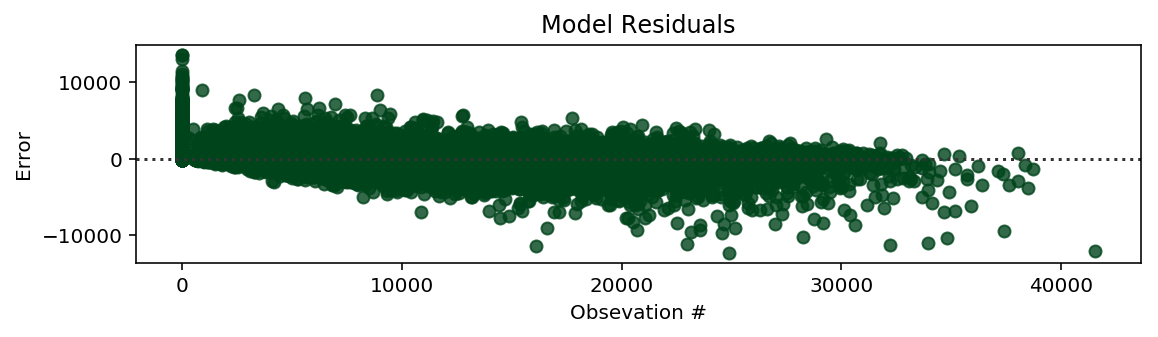

In [23]:
plt.figure(figsize=(9,2))
plt.plot(train_df.Date.values, y_train, color='#CFCCC7')
plt.ylim(0,40_000)
plt.title("Ground Truth: Salse by Day")
plt.ylabel('Sales (Daily)')
plt.xlabel('Date');

plt.figure(figsize=(9,2))
plt.plot(train_df.Date.values, rfr_pred, color='#A1D99B')
plt.ylim(0,40_000)
plt.title("Random Forest Regressor: Forecasted Sales Per Day")
plt.ylabel('Sales (Daily)')
plt.xlabel('Date');

# Plotting the residuals of y and pred_y
plt.figure(figsize=(9,2))
sns.residplot(y_train,rfr_pred, color='#00441B')
plt.title('Model Residuals')
plt.xlabel('Obsevation #')
plt.ylabel('Error');

### Grid Search

I wanted do a grid search on the entire dataset. Yet I was running into memory and time issuse when attempting to run the entire grid search on my local laptop. For this notebook I have to opted to avoid complete the grid search. If you wanted to see how to complete grid search this pipeline. Feel free to check out my [Grid Search notebook](kavisekhon.com)

### Save and Load Pipelines

In [24]:
# Save Pipeline (in case we run into memory issues)
joblib.dump(lr_pipeline, 'Models/time_series_lr_model.sav')
joblib.dump(rfr_pipeline, 'Models/time_series_rfr_model.sav')

['Models/time_series_rfr_model.sav']

In [25]:
# Load Pipeline (in case the kernel crashes)
lr_pipeline = joblib.load('Models/time_series_lr_model.sav')
rfr_pipeline = joblib.load('Models/time_series_rfr_model.sav')

### Save Prediction File

In [26]:
y_test_pred = rfr_pipeline.predict(X_test)
submission = pd.DataFrame({'id': np.arange(1,41089),
              'Sales':y_test_pred})
submission.to_csv('/Users/kavi/Desktop/predictions.csv', index=False)

### General Notes
-- Data with a trend is non-stationary, Data without any trend is stationary<br>
-- Whether a trend being present in the dataset is a subject observation<br>
-- Removing a trend from your data is normally done for statistical models, but does not always work for machine learing model<br>
-- Building a Correlation Matrix Plot for the feature between the multivariate feature at different time lags, could help us find correlation within a lagged timeframe but may mask non-linearity in our model<br>

Author: Kavi Sekhon